# 3. Convolutional Neural Networks

In the previous section, we built and trained a simple model to classify ASL images. The model was able to learn how to correctly classify the training dataset with very high accuracy, but, it did not perform nearly as well on validation dataset. This behavior of not generalizing well to non-training data is called [overfitting](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html), and in this section, we will introduce a popular kind of model called a [convolutional neural network](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) that is especially good for reading images and classifying them.

## 3.1 Objectives

* Prep data specifically for a CNN
* Create a more sophisticated CNN model, understanding a greater variety of model layers
* Train a CNN model and observe its performance

In [1]:
import torch.nn as nn
import pandas as pd
import torch

from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

False

## 3.2 Loading and Preparing the Data

### 3.2.1 Preparing Images

Let's begin by loading our DataFrames like we did in the previous lab:

In [2]:
train_df = pd.read_csv("data/asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv("data/asl_data/sign_mnist_valid.csv")

This ASL data is already flattened.

In [3]:
sample_df = train_df.head().copy()  # Grab the top 5 rows
sample_df.pop('label')
sample_x = sample_df.values
sample_x

array([[107, 118, 127, ..., 204, 203, 202],
       [155, 157, 156, ..., 103, 135, 149],
       [187, 188, 188, ..., 195, 194, 195],
       [211, 211, 212, ..., 222, 229, 163],
       [164, 167, 170, ..., 163, 164, 179]], shape=(5, 784))

In [4]:
sample_x.shape

(5, 784)

In this format, we don't have all the information about which pixels are near each other. Because of this, we can't apply convolutions that will detect features. Let's [reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) our dataset so that they are in a 28x28 pixel format. This will allow our convolutions to associate groups of pixels and detect important features.

Note that for the first convolutional layer of our model, we need to have not only the height and width of the image, but also the number of [color channels](https://www.photoshopessentials.com/essentials/rgb/). Our images are grayscale, so we'll just have 1 channel.

That means that we need to convert the current shape `(5, 784)` to `(5, 1, 28, 28)`. With [NumPy](https://numpy.org/doc/stable/index.html) arrays, we can pass a `-1` for any dimension we wish to remain the same.

In [5]:
IMG_HEIGHT = 28
IMG_WIDTH = 28
IMG_CHS = 1

sample_x = sample_x.reshape(-1, IMG_CHS, IMG_HEIGHT, IMG_WIDTH)
sample_x.shape

(5, 1, 28, 28)

### 3.2.2 Create a Dataset

Let's add the steps above into our `MyDataset` class.

In [6]:
transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True)
])

# Sample dataset class
class NumpyDataset(Dataset):
    def __init__(self, data, transform=None):
        label = data.pop('label')
        data = data.values  # shape: (N, 28*28)
        print(f"train data shape before rehsape{data.shape}")
        data = data.reshape(-1, IMG_CHS, IMG_WIDTH, IMG_HEIGHT)
        print(f"data shape after rehsape{data.shape}")
        self.label = label
        self.data = torch.tensor(data, dtype=torch.float32)
        self.transform = transform
        assert len(self.data) == len(self.label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.label[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

### 3.2.3 Create a DataLoader

Next, let's create the DataLoader from the Dataset

In [7]:
BATCH_SIZE = 32

train_data = NumpyDataset(train_df)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
train_N = len(train_loader.dataset)

valid_data = NumpyDataset(valid_df)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)
valid_N = len(valid_loader.dataset)

train data shape before rehsape(27455, 784)
data shape after rehsape(27455, 1, 28, 28)
train data shape before rehsape(7172, 784)
data shape after rehsape(7172, 1, 28, 28)


Let's grab a batch from the DataLoader to make sure it works.

In [8]:
batch = next(iter(train_loader))
batch

[tensor([[[[128., 130., 131.,  ..., 143., 144., 144.],
           [129., 131., 133.,  ..., 145., 145., 146.],
           [130., 133., 135.,  ..., 146., 148., 148.],
           ...,
           [150., 153., 154.,  ..., 170., 170., 170.],
           [151., 152., 154.,  ..., 170., 170., 170.],
           [150., 153., 153.,  ..., 170., 170., 170.]]],
 
 
         [[[190., 192., 193.,  ..., 189., 188., 187.],
           [193., 194., 194.,  ..., 192., 190., 190.],
           [194., 195., 197.,  ..., 194., 194., 193.],
           ...,
           [220., 220., 222.,  ..., 222., 221., 218.],
           [220., 221., 221.,  ..., 222., 221., 219.],
           [221., 222., 221.,  ..., 223., 221., 220.]]],
 
 
         [[[230., 230., 231.,  ..., 204., 202., 199.],
           [234., 233., 234.,  ..., 207., 204., 202.],
           [236., 236., 236.,  ..., 211., 207., 204.],
           ...,
           [139., 144., 141.,  ...,  40.,  41.,  53.],
           [151., 148., 145.,  ...,  40.,  43.,  50.],
     

It looks different, but let's check the `shape`s to be sure.

In [9]:
batch[0].shape

torch.Size([32, 1, 28, 28])

In [10]:
batch[1].shape

torch.Size([32])

## 3.3 Creating a Convolutional Model

These days, many data scientists start their projects by borrowing model properties from a similar project. Assuming the problem is not totally unique, there's a great chance that people have created models that will perform well which are posted in online repositories like [TensorFlow Hub](https://www.tensorflow.org/hub) and the [NGC Catalog](https://ngc.nvidia.com/catalog/models). Today, we'll provide a model that will work well for this problem.

We covered many of the different kinds of layers in the lecture, and we will go over them all here with links to their documentation. When in doubt, read the official documentation (or ask [Stack Overflow](https://stackoverflow.com/)).

In [11]:
num_classes = 24
kernel_size = 3
flattened_img_size = 75 * 3 * 3         # calculated based on output form convolution layers

model = nn.Sequential(
    # First convolution
    nn.Conv2d(IMG_CHS, 25, kernel_size, stride=1, padding=1),  # 25 x 28 x 28
    nn.BatchNorm2d(25),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),  # 25 x 14 x 14
    # Second convolution
    nn.Conv2d(25, 50, kernel_size, stride=1, padding=1),  # 50 x 14 x 14
    nn.BatchNorm2d(50),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.MaxPool2d(2, stride=2),  # 50 x 7 x 7
    # Third convolution
    nn.Conv2d(50, 75, kernel_size, stride=1, padding=1),  # 75 x 7 x 7
    nn.BatchNorm2d(75),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),  # 75 x 3 x 3
    # Flatten to Dense
    nn.Flatten(),
    nn.Linear(flattened_img_size, 512),
    nn.Dropout(.3),
    nn.ReLU(),
    nn.Linear(512, num_classes)
)

### 3.3.1 [Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

<img src="images/conv2d.png" width=300 />

These are our 2D convolutional layers. Small kernels will go over the input image and detect features that are important for classification. Earlier convolutions in the model will detect simple features such as lines. Later convolutions will detect more complex features. Let's look at our first Conv2D layer:
```Python
nn.Conv2d(IMG_CHS, 25, kernel_size, stride=1, padding=1)
```
25 refers to the number of filters that will be learned. Even though `kernel_size = 3`, PyTorch will assume we want 3 x 3 filters. Stride refer to the step size that the filter will take as it passes over the image. Padding refers to whether the output image that's created from the filter will match the size of the input image.

### 3.3.2 [BatchNormalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)

Like normalizing our inputs, batch normalization scales the values in the hidden layers to improve training. [Read more about it in detail here](https://blog.paperspace.com/busting-the-myths-about-batch-normalization/).

There is a debate on best where to put the batch normalization layer. [This Stack Overflow post](https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout) compiles many perspectives.

### 3.3.3 [MaxPool2D](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

<img src="images/maxpool2d.png" width=300 />
Max pooling takes an image and essentially shrinks it to a lower resolution. It does this to help the model be robust to translation (objects moving side to side), and also makes our model faster.

### 3.3.4 [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

<img src="images/dropout.png" width=360 />
Dropout is a technique for preventing overfitting. Dropout randomly selects a subset of neurons and turns them off, so that they do not participate in forward or backward propagation in that particular pass. This helps to make sure that the network is robust and redundant, and does not rely on any one area to come up with answers.    

### 3.3.5 [Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)

Flatten takes the output of one layer which is multidimensional, and flattens it into a one-dimensional array. The output is called a feature vector and will be connected to the final classification layer.

### 3.3.6 [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

We have seen dense linear layers before in our earlier models. Our first dense layer (512 units) takes the feature vector as input and learns which features will contribute to a particular classification. The second dense layer (24 units) is the final classification layer that outputs our prediction.

## 3.4 Summarizing the Model

This may feel like a lot of information, but don't worry. It's not critical that to understand everything right now in order to effectively train convolutional models. Most importantly we know that they can help with extracting useful information from images, and can be used in classification tasks.

In [12]:
model = torch.compile(model.to(device))
model

OptimizedModule(
  (_orig_mod): Sequential(
    (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(50, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=675, out_features=512, bias=True)
    (15): Dropout

Since the problem we are trying to solve is still the same (classifying ASL images), we will continue to use the same `loss_function` and `accuracy` metric.

In [13]:
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())

In [14]:
def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

### 3.5 Training the Model

Despite the very different model architecture, the training looks exactly the same.

In [15]:
# for ploting purpose
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

In [16]:
def train():
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))
    train_losses.append(loss/train_N)
    train_accuracy.append(accuracy)

In [17]:
def validate():
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))
    val_losses.append(loss/train_N)
    val_accuracy.append(accuracy)

In [18]:
epochs = 20

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train()
    validate()

Epoch: 0
Train - Loss: 266.7284 Accuracy: 0.9083
Valid - Loss: 52.5754 Accuracy: 0.9253
Epoch: 1
Train - Loss: 22.7523 Accuracy: 0.9926
Valid - Loss: 24.1637 Accuracy: 0.9656
Epoch: 2
Train - Loss: 6.3902 Accuracy: 0.9981
Valid - Loss: 21.6793 Accuracy: 0.9720
Epoch: 3
Train - Loss: 14.5189 Accuracy: 0.9951
Valid - Loss: 21.9240 Accuracy: 0.9713
Epoch: 4
Train - Loss: 8.9488 Accuracy: 0.9973
Valid - Loss: 68.7346 Accuracy: 0.9257
Epoch: 5
Train - Loss: 5.8440 Accuracy: 0.9983
Valid - Loss: 14.0847 Accuracy: 0.9770
Epoch: 6
Train - Loss: 9.7778 Accuracy: 0.9965
Valid - Loss: 31.3516 Accuracy: 0.9635
Epoch: 7
Train - Loss: 2.0311 Accuracy: 0.9993
Valid - Loss: 8.8311 Accuracy: 0.9869
Epoch: 8
Train - Loss: 5.5218 Accuracy: 0.9980
Valid - Loss: 74.5656 Accuracy: 0.9163
Epoch: 9
Train - Loss: 3.6544 Accuracy: 0.9989
Valid - Loss: 30.3997 Accuracy: 0.9773
Epoch: 10
Train - Loss: 6.5685 Accuracy: 0.9977
Valid - Loss: 119.8928 Accuracy: 0.8834
Epoch: 11
Train - Loss: 4.9243 Accuracy: 0.9983
V

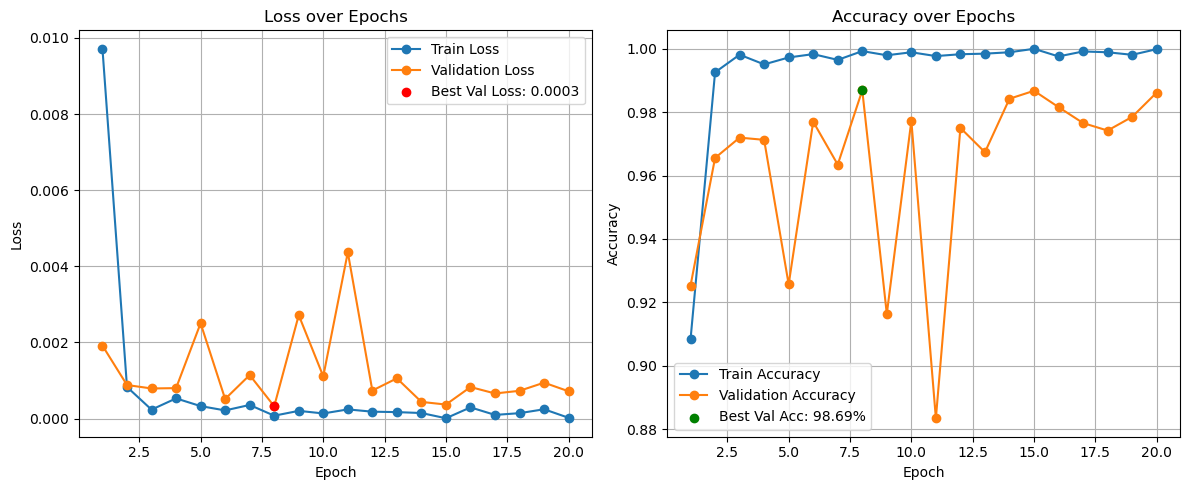

In [19]:
epochs = range(1, len(train_losses) + 1)

# Identify best performance (lowest loss, highest accuracy)
best_val_loss_idx = val_losses.index(min(val_losses))
best_val_acc_idx = val_accuracy.index(max(val_accuracy))

plt.figure(figsize=(12, 5))

# ---- LOSS PLOT ----
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.scatter(best_val_loss_idx + 1, val_losses[best_val_loss_idx], color='red', zorder=5, label=f'Best Val Loss: {val_losses[best_val_loss_idx]:.4f}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

# ---- ACCURACY PLOT ----
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.scatter(best_val_acc_idx + 1, val_accuracy[best_val_acc_idx], color='green', zorder=5, label=f'Best Val Acc: {val_accuracy[best_val_acc_idx]*100:.2f}%')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 3.5.1 Discussion of Results

It looks like this model is significantly improved! The training accuracy is very high, and the validation accuracy has improved as well. This is a great result, as all we had to do was swap in a new model.

You may have noticed the validation accuracy jumping around. This is an indication that our model is still not generalizing perfectly. Fortunately, there's more that we can do.

## 3.6 Summary

In this section, we utilized several new kinds of layers to implement a CNN, which performed better than the more simple model used in the last section. Hopefully the overall process of creating and training a model with prepared data is starting to become even more familiar.